# MOVIE RECOMMENDATION SYSTEM

## Overview

Developing a movie recommendation system to improve the user experience in the entertainment industry. By leveraging historical data , our project aims to enhance customer satisfaction by providing personalized movie suggestions, fostering engagement, and driving user retention

##  Business Understanding</small>

### Background
In this project, our objective is to develop a movie recommendation system utilizing the MovieLens dataset sourced from the GroupLens research lab at the University of Minnesota. This dataset contains user ratings for movies and is widely recognized in academic research and machine learning experiments.

### Business Problem
The primary goal is to enhance the user experience by providing personalized movie recommendations. The system will suggest the top 5 movies to each user based on their previous ratings. This tailored recommendation system aims to boost user engagement, satisfaction, and overall retention within a movie-streaming platform.

### User Interaction
Users will interact with the system through the movie-streaming platform, providing feedback through explicit ratings or indicating preferences through likes, dislikes, or their viewing history. The system's design should seamlessly integrate into the platform's user interface, ensuring a smooth and enjoyable user experience.

### Collaborative Filtering
The recommendation system will heavily rely on collaborative filtering as its primary mechanism. This technique involves making predictions about a user's preferences by aggregating insights from numerous users. Additionally, we may explore a hybrid approach, incorporating content-based filtering to tackle the cold start problem – a scenario where new or unrated movies necessitate recommendations.

### Evaluation Metrics
To gauge the effectiveness of our recommendation system, we will employ pertinent metrics. Traditional regression metrics like Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) will be utilized to quantify the accuracy of predictions. These metrics offer valuable insights into the system's proficiency in forecasting user preferences, guiding us in refining its performance.

**DATA UNDERSTANDING**

Dataset - * The dataset used for this project can be found in [Kaggle](https://grouplens.org/datasets/movielens/latest/)

tag.csv that contains tags applied to movies by users:
userId, movieId, tag, timestamp

rating.csv that contains ratings of movies by users:
userId, movieId, rating, timestamp

movie.csv that contains movie information:
movieId, title, genres

**PROBLEM STATEMENT**

With so many movie alternatives available nowadays, people find it difficult to choose films that suit their tastes due to information overload. Manual searches take a lot of time, which causes decision fatigue and lowers user engagement on a platform. A customized movie recommendation system that makes use of user-specific information and collaborative filtering methods will address this. By creating an effective recommendation engine that smoothly connects with user profiles, this project seeks to improve user satisfaction and retention by enabling a more efficient and enjoyable exploration of the extensive movie catalogs.

**OBJECTIVES**

Main objective:

* To provide personalized movie recommendations tailored to individual user preferences. 

Specific objectives:

* To find the most popular movies by genre 
* To build a recommendation system that scales efficiently with a growing user base and an expanding movie catalog.
* To provide near-real-time movie recommendations based on user interactions

##  Reading the data

In [51]:
# Importing the necessary libraries 
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")


import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import surprise


In [52]:
# Loading the datasets

tags_data = pd.read_csv("tags.csv")
movies_data = pd.read_csv("movies.csv")
ratings_data = pd.read_csv("ratings.csv")

# Preview the shape of the dataset
print('Dataframe shape {}'.format(tags_data.shape))
print('Dataframe shape {}'.format(movies_data.shape))
print('Dataframe shape {}'.format(ratings_data.shape))

Dataframe shape (3683, 4)
Dataframe shape (9742, 3)
Dataframe shape (100836, 4)


In [53]:
# Merge movies_data and tags_data on 'movieId'
merged_df = pd.merge(movies_data, tags_data, on='movieId', how='inner')

# Merge the result with ratings_data on 'movieId'
merged_df = pd.merge(merged_df, ratings_data, on='movieId', how='inner')

# Display the resulting DataFrame
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483


In [54]:
merged_df.shape

(233213, 9)

In [55]:
#  Creating a class for exploring and analyzing Pandas DataFrames.
class DataExplorer:
    def __init__(self, data):
        """
        Initialize the DataExplorer class with a dataset.
        :param data: Pandas DataFrame
        """
        self.data = data
        
    def check_head(self, rows=5):
        """
        Display the first few rows of the dataset.
        :return: Pandas DataFrame showing the head of the dataset
        """
        return self.data.head(rows)
    
    def check_info(self):
        """
        Display information about the dataset (data types, memory usage, etc.).
        """
        return self.data.info()
    
    def check_describe(self):
        """
        Generate descriptive statistics of the dataset (count, mean, etc.).
        :return: Pandas DataFrame with descriptive statistics
        """
        return self.data.describe()
    

In [56]:
# Instatiating the class
explorer = DataExplorer(merged_df)

# Check the head of the dataset
print("Head of the dataset:")
print(explorer.check_head())

# Check dataset info
print("\nDataset info:")
explorer.check_info()

# Check dataset description
print("\nDataset statistics:")
print(explorer.check_describe())

Head of the dataset:
   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId_x    tag  timestamp_x  userId_y  rating  timestamp_y  
0       336  pixar   1139045764         1     4.0    964982703  
1       336  pixar   1139045764         5     4.0    847434962  
2       336  pixar   1139045764         7     4.5   1106635946  
3       336  pixar   1139045764        15     2.5   1510577970  
4       336  pixar   1139045764        17     4.5   1305696483  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 233213 entries, 0 to 233212
Data columns (total 9 columns):
 

# Data Cleaning

This section prepares the data for EDA and modeling. The dataset will be checked for:

- duplicated rows
- missing values
- extracting release year from title

In [57]:
# Checking for missing values in the dataset
merged_df.isnull().sum()

movieId        0
title          0
genres         0
userId_x       0
tag            0
timestamp_x    0
userId_y       0
rating         0
timestamp_y    0
dtype: int64

The data has a no missing values.

In [58]:
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483


In [59]:
# Function to extract the year from the title
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    return match.group(1) if match else None

# Apply the function to create a new 'year' column
merged_df['year'] = merged_df['title'].apply(extract_year)

# Remove the year from the 'title' column
merged_df['title'] = merged_df['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

# Display the updated DataFram
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483,1995


In [60]:
# # Split the genres column into a list of genres
# merged_df['genres'] = merged_df['genres'].str.split('|')
merged_df = merged_df.explode('genres')

# Display the updated DataFrame
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483,1995


In [61]:
# Check for null values within the lists in the 'genres' column
null_values_in_genres = merged_df['genres'].apply(lambda x: any(pd.isnull(i) for i in x))

# Display the rows where null values are present in the 'genres' column
rows_with_null_values = merged_df[null_values_in_genres]
print("Rows with null values in the 'genres' column:")
print(rows_with_null_values)

Rows with null values in the 'genres' column:
Empty DataFrame
Columns: [movieId, title, genres, userId_x, tag, timestamp_x, userId_y, rating, timestamp_y, year]
Index: []


The genre column has no missing values

In [62]:
# Converting year to date-time format
merged_df['year'] = pd.to_datetime(merged_df['year'])
# Keeping the year only
merged_df['year'] = merged_df['year'].dt.year
# previewing the changes
merged_df.head()

,movieId,title,genres,userId_x,tag,timestamp_x,userId_y,rating,timestamp_y,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,1,4.0,964982703,1995.0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,5,4.0,847434962,1995.0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,7,4.5,1106635946,1995.0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,15,2.5,1510577970,1995.0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,336,pixar,1139045764,17,4.5,1305696483,1995.0


# Explarotary Data Analysis

### Univariate Analysis

In [63]:
# checking summary stats for the dataset
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
movieId,233213.0,1.232000e+04,2.824392e+04,1.000000e+00,2.960000e+02,1.198000e+03,4.638000e+03,1.935650e+05
userId_x,233213.0,4.706836e+02,1.533296e+02,2.000000e+00,4.240000e+02,4.770000e+02,5.990000e+02,6.100000e+02
timestamp_x,233213.0,1.384774e+09,1.534621e+08,1.137179e+09,1.242494e+09,1.457901e+09,1.498457e+09,1.537099e+09
userId_y,233213.0,3.096882e+02,1.782064e+02,1.000000e+00,1.560000e+02,3.090000e+02,4.600000e+02,6.100000e+02
rating,233213.0,3.966535e+00,9.686373e-01,5.000000e-01,3.500000e+00,4.000000e+00,5.000000e+00,5.000000e+00
timestamp_y,233213.0,1.213524e+09,2.250448e+08,8.281246e+08,1.017365e+09,1.217325e+09,1.443201e+09,1.537799e+09
year,233210.0,1.994435e+03,1.171456e+01,1.921000e+03,1.994000e+03,1.994000e+03,2.000000e+03,2.018000e+03


In [64]:
# checking values in tag column
merged_df['tag'].value_counts()

sci-fi               2527
thought-provoking    2487
twist ending         2434
atmospheric          2227
dark comedy          2056
                     ... 
film history            1
britpop                 1
creativity              1
remaster                1
deafness                1
Name: tag, Length: 1584, dtype: int64

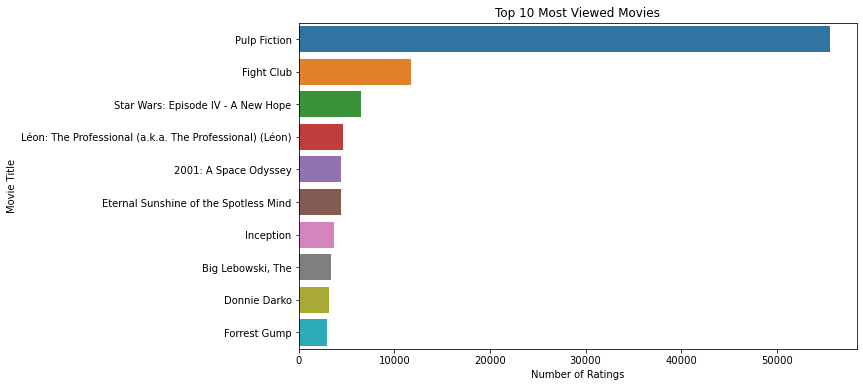

In [65]:
# Count the number of ratings for each movie
movie_ratings = merged_df['title'].value_counts().head(10)

# Plotting the top 10 most viewed movies
plt.figure(figsize=(10, 6))
sns.barplot(x=movie_ratings.values, y=movie_ratings.index)
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Most Viewed Movies')
plt.show()


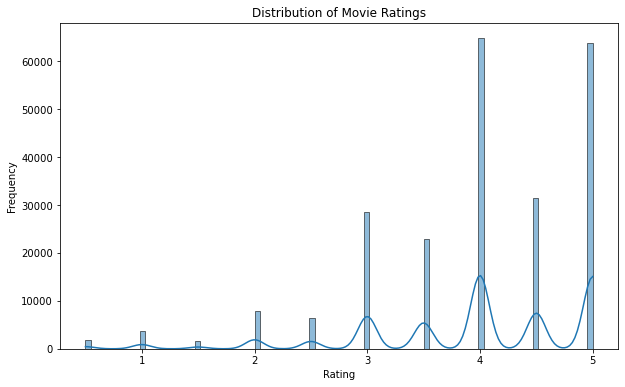

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['rating'], kde=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()

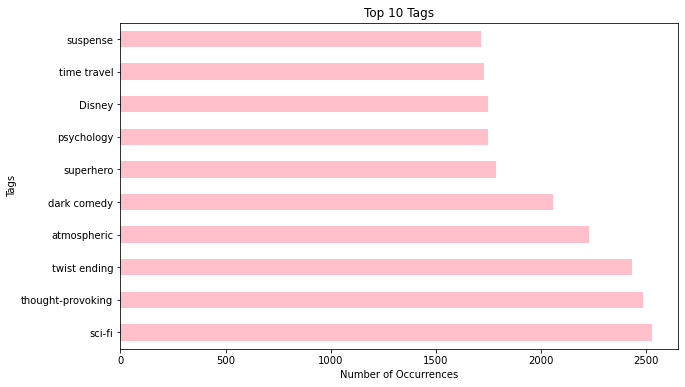

In [67]:
# Plot a bar chart for the top tags
tag_counts = merged_df['tag'].value_counts()
top_tags = tag_counts.head(10)

plt.figure(figsize=(10, 6))
top_tags.plot(kind='barh', color='pink')
plt.title('Top 10 Tags')
plt.xlabel('Number of Occurrences')
plt.ylabel('Tags')
plt.show()

In [68]:
def find_genres(movies_df):
    """
    Find and count genres in a movies DataFrame.

    """
    genres = {}  # dictionary to store different genre values

    for genre in movies_df['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1

    return genres

# usage:
genre_counts = find_genres(movies_data)
genre_counts

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

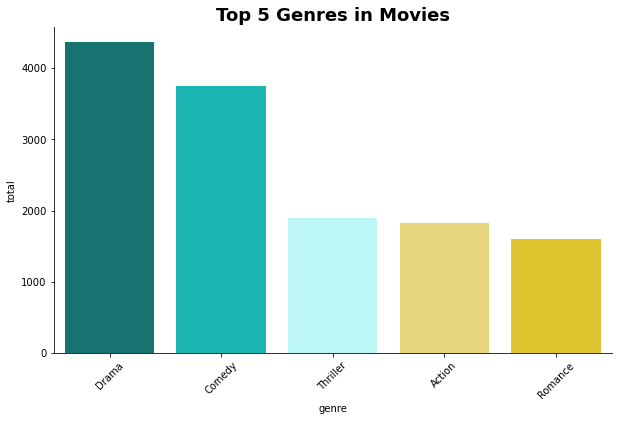

In [69]:
# Create a DataFrame from the genre_counts dictionary
df_plot = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['total']).reset_index()
df_plot = df_plot.rename(columns={'index': 'genre'})

# Sort the DataFrame by 'total' in descending order
df_plot = df_plot.sort_values(by='total', ascending=False)

# Set the number of top genres to display
top_n_genres = 5

# Create the bar plot for the top 5 genres
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_plot.head(top_n_genres), x='genre', y='total', palette=['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811'])
ax.set_title('Top 5 Genres in Movies', fontsize=18, weight='bold')
sns.despine()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

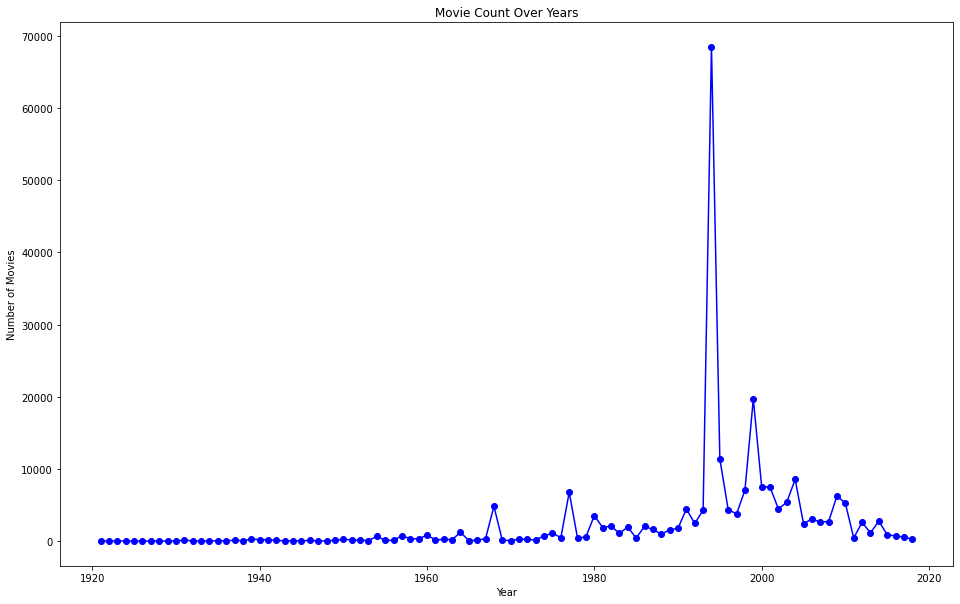

In [70]:
# Plot a line chart for movie count over the years
movie_count_per_year = merged_df['year'].value_counts().sort_index()

plt.figure(figsize=(16, 10))
movie_count_per_year.plot(kind='line', marker='o', color='blue')
plt.title('Movie Count Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()

In [71]:
v_rate = dict(merged_df['rating'].value_counts())

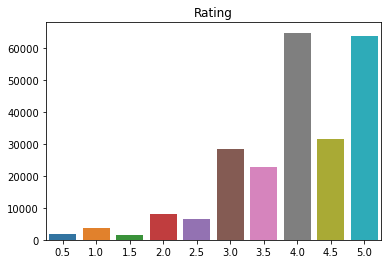

<Figure size 1008x576 with 0 Axes>

In [72]:
plt.title('Rating')
sns.barplot(data=merged_df, x= list(v_rate.keys()),y=list(v_rate.values()))
plt.figure(figsize=(14, 8))
plt.show()

# Bivariate Analysis

In [73]:
merged_df.columns

Index(['movieId', 'title', 'genres', 'userId_x', 'tag', 'timestamp_x',
       'userId_y', 'rating', 'timestamp_y', 'year'],
      dtype='object')

In [74]:
#Analysis of rating given by the user 
no_of_rated_movies_per_user = merged_df.groupby(by='userId_y')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user

userId_y
474    2455
414    2343
599    2100
68     1791
610    1701
       ... 
406      10
499       9
207       8
578       6
175       5
Name: rating, Length: 610, dtype: int64

In [75]:
no_of_rated_movies_per_user.describe()

count     610.000000
mean      382.316393
std       365.395411
min         5.000000
25%       106.500000
50%       280.000000
75%       525.000000
max      2455.000000
Name: rating, dtype: float64

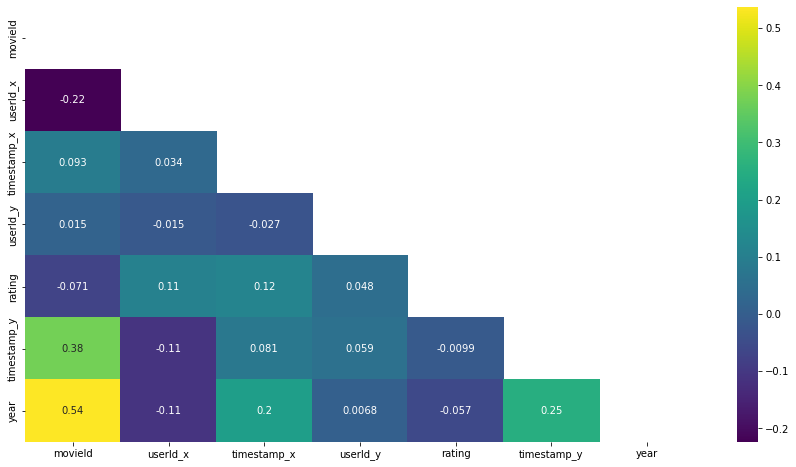

In [76]:
#plot correlation
plt.figure(figsize=(15, 8))
# Create a mask to display only the upper half of the matrix
mask = np.triu(merged_df.corr())
sns.heatmap(merged_df.corr(), annot=True, cmap='viridis', mask=mask)
plt.show()

### Most popular movies by genre

In [144]:
# Merge datasets based on movieId
movie_ratings = pd.merge(ratings_data, movies_data, on='movieId')

# Function to get the most popular movies by genre
def get_most_popular_by_genre(genre, top_n=5):
    # Filter movies by genre
    genre_movies = movie_ratings[movie_ratings['genres'].str.contains(genre, case=False)]

    # Calculate average ratings and number of ratings for each movie
    genre_movie_stats = genre_movies.groupby('title').agg({'rating': ['mean', 'count']})

    # Rename columns for clarity
    genre_movie_stats.columns = ['avg_rating', 'num_ratings']

    # Sort by average rating and number of ratings
    sorted_genre_movies = genre_movie_stats.sort_values(by=['avg_rating', 'num_ratings'], ascending=[False, False])

    # Select the top N movies
    top_movies = sorted_genre_movies.head(top_n)

    return top_movies


In [145]:
get_most_popular_by_genre('Comedy', top_n=5)

# Display the result
#print(f"Top 5 Most Popular genre Movies:")
#print(top_action_movies)

,avg_rating,num_ratings
title,,
Belle époque (1992),5.0,2
Jonah Who Will Be 25 in the Year 2000 (Jonas qui aura 25 ans en l'an 2000) (1976),5.0,2
Lesson Faust (1994),5.0,2
12 Chairs (1976),5.0,1
A Flintstones Christmas Carol (1994),5.0,1


## Building Recommendation System (Collaborative Filtering using Surprise library)

In [77]:
# Building Recommendation System (Collaborative Filtering using Surprise library)
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [78]:
# Load data for Surprise library
reader = Reader()
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

In [79]:
# Use SVD algorithm
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8744  0.8745  0.8784  0.8706  0.8712  0.8738  0.0028  
MAE (testset)     0.6717  0.6728  0.6744  0.6689  0.6698  0.6715  0.0020  
Fit time          4.93    5.01    5.44    5.92    5.19    5.30    0.36    
Test time         0.15    0.15    0.25    0.14    0.33    0.20    0.07    


{'test_rmse': array([0.87438012, 0.8744857 , 0.87840906, 0.87059706, 0.87120936]),
 'test_mae': array([0.67174845, 0.67282453, 0.67436057, 0.66892498, 0.6698169 ]),
 'fit_time': (4.927682161331177,
  5.007375955581665,
  5.4421374797821045,
  5.921461582183838,
  5.191859245300293),
 'test_time': (0.14975643157958984,
  0.14808368682861328,
  0.2493150234222412,
  0.13961482048034668,
  0.32813119888305664)}

In [80]:
# Train the model on the entire dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

In [81]:
# Make recommendations for a specific user
user_id = 7
user_movies = ratings_data[ratings_data['userId'] == user_id]['movieId']
unrated_movies = movies_data[~movies_data['movieId'].isin(user_movies)]['movieId']

# Generate predictions for unrated movies
user_predictions = [(movie, svd.predict(user_id, movie).est) for movie in unrated_movies]

# Sort predictions by estimated rating
sorted_predictions = sorted(user_predictions, key=lambda x: x[1], reverse=True)

In [82]:
# Display top 5 movie recommendations
top_recommendations = sorted_predictions[:5]
print("Top 5 Movie Recommendations:")
for movie_id, estimated_rating in top_recommendations:
    movie_title = movies_data[movies_data['movieId'] == movie_id]['title'].values[0]
    print(f"Movie: {movie_title}, Estimated Rating: {estimated_rating}")

Top 5 Movie Recommendations:
Movie: Shining, The (1980), Estimated Rating: 4.521034467146356
Movie: Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001), Estimated Rating: 4.2736961206960835
Movie: Bridge on the River Kwai, The (1957), Estimated Rating: 4.249641908366097
Movie: Princess Bride, The (1987), Estimated Rating: 4.243322639954739
Movie: Trainspotting (1996), Estimated Rating: 4.19542632068977


**CONTENT BASED**

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [84]:
def genres_and_titles_to_string(row):
    genres = row['genres'].split('|')
    genres = ' '.join(''.join(j) for j in genres)
    
    title = row['title']
    
    return "%s %s" % (genres, title)

In [85]:
movies_data['string'] = movies_data.apply(genres_and_titles_to_string, axis = 1)

In [86]:
#create a tf-idf vectorizer object
tfidf = TfidfVectorizer(max_features = 200)

In [87]:
#create the TF-IDF matrix
X = tfidf.fit_transform(movies_data['string'])
X.shape

(9742, 200)

In [88]:
movie2idx = pd.Series(movies_data.index, index = movies_data['title'])
movie2idx

title
Toy Story (1995)                                0
Jumanji (1995)                                  1
Grumpier Old Men (1995)                         2
Waiting to Exhale (1995)                        3
Father of the Bride Part II (1995)              4
                                             ... 
Black Butler: Book of the Atlantic (2017)    9737
No Game No Life: Zero (2017)                 9738
Flint (2017)                                 9739
Bungo Stray Dogs: Dead Apple (2018)          9740
Andrew Dice Clay: Dice Rules (1991)          9741
Length: 9742, dtype: int64

In [89]:
def recommend(movie, K):
    #get the row in the df for this movie
    idx = movie2idx[movie]
    if type(idx) == pd.Series:
        idx = idx.iloc[0]
        
    #calculate the pairwise similarities for this movie:
    movie_index = X[idx]
    scores = cosine_similarity(movie_index, X)
    
    #currently the array is 1xN, make it 1D array
    scores = scores.flatten()
    
    #get the indices of the highest scoring movies
    recommended_idx = (-scores).argsort()[1:K+1]
    
    #return the titles of the recommendations
    return movies_data['title'].iloc[recommended_idx]

In [90]:
recommend('Toy Story (1995)',7)

2355                        Toy Story 2 (1999)
12                                Balto (1995)
1                               Jumanji (1995)
7355                        Toy Story 3 (2010)
599     Wallace & Gromit: A Close Shave (1995)
209                               Gordy (1995)
4604      Ninja Scroll (Jûbei ninpûchô) (1995)
Name: title, dtype: object

In [91]:
movies_data[movies_data['genres']=='Comedy']

,movieId,title,genres,string
4,5,Father of the Bride Part II (1995),Comedy,Comedy Father of the Bride Part II (1995)
17,18,Four Rooms (1995),Comedy,Comedy Four Rooms (1995)
18,19,Ace Ventura: When Nature Calls (1995),Comedy,Comedy Ace Ventura: When Nature Calls (1995)
58,65,Bio-Dome (1996),Comedy,Comedy Bio-Dome (1996)
61,69,Friday (1995),Comedy,Comedy Friday (1995)
...,...,...,...,...
9695,184791,Fred Armisen: Standup for Drummers (2018),Comedy,Comedy Fred Armisen: Standup for Drummers (2018)
9704,185473,Blockers (2018),Comedy,Comedy Blockers (2018)
9716,188797,Tag (2018),Comedy,Comedy Tag (2018)
9726,190209,Jeff Ross Roasts the Border (2017),Comedy,Comedy Jeff Ross Roasts the Border (2017)


In [92]:
recommend('Tag (2018)', 5)

9685    Tom Segura: Disgraceful (2018)
9716                        Tag (2018)
9718                 Boundaries (2018)
9684                The Clapper (2018)
9723             BlacKkKlansman (2018)
Name: title, dtype: object

In [93]:
# # Create a set of English stopwords
# stop_words = set(stopwords.words('english'))

# # Function that takes in movie title as input and outputs most similar movies
# def get_recommendations(title, data_frame):
#     # Get the index of the movie that matches the title
#     idx = data_frame.index[data_frame['title'] == title][0]

#     # Create a TF-IDF vectorizer
#     tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)

#     # Fit and transform the movie titles into TF-IDF vectors
#     tfidf_matrix = tfidf_vectorizer.fit_transform(data_frame['title'])

#     # Get the pairwsie similarity scores of all movies with that movie
#     sim_scores = list(enumerate(cosine_similarity(tfidf_matrix, tfidf_matrix[idx])))

#     # Sort the movies based on the similarity scores
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     # Get the scores of the 10 most similar movies
#     sim_scores = sim_scores[1:11]

#     # Get the movie indices
#     movie_indices = [i[0] for i in sim_scores]

#     # Return the top 10 most similar movies
#     return data_frame['title'].iloc[movie_indices]

# recommended_movies = get_recommendations('Toy Story (1995)', movies_data)
# print(recommended_movies)